In [2]:
import logging
# Configure logging
logging.basicConfig(
    level=logging.DEBUG,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Specify the log message format
    datefmt='%Y-%m-%d %H:%M:%S',  # Specify the date format
    handlers=[
        #logging.FileHandler('app.log'),  # Log messages to a file
        logging.StreamHandler()  # Also output log messages to the console
    ]
)
logger = logging.getLogger(__name__)
import pickle 
import networkx as nx
import time
from datetime import datetime, timezone
import os
import sys
import pandas as pd

In [1]:
"""The data stored in pickle format with version: 0.7.5 (python 3.7).
The type of graph object：networkx.classes.multidigraph.MultiDiGraph
Numbers of nodes: 2973489
Numbers of edges: 13551303
Average degree:   4.5574
Nodes' features：
    // The label. 1 means fishing mark node, otherwise 0.
    G.nodes[nodeName]['isp']；

Edges' features:
    G[node1][node2][0]['amount']        // The amount mount of the transaction.
    G[node1][node2][0]['timestamp']     // The timestamp of the transaction.				
							
* Notes * 
"""



def load_pickle(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)
logger.info("Loading the graph")
start = time.time()
G = load_pickle('/mnt/data/ethereum-phishing-transaction-network/MulDiGraph.pkl')
logger.info(f"Graph loaded in {time.time()-start} seconds.")
logger.info(f'Number of nodes: {G.number_of_nodes()}')
logger.info(f'Number of edges: {G.number_of_edges()}')

logger.info("Processing the graph")
uniq = set()
start = time.time()
min_time = 1e20
max_time = 0
from_address = []
to_address = []
time_stamps = []
amounts = []

for ind, edge in enumerate(nx.edges(G)):
    (u, v) = edge
    eg = G[u][v][0]
    amo, tim = eg['amount'], eg['timestamp']
    uniq.add((u, v, tim))
    #uniq.add((u, v, amo, tim))
    min_time = min(min_time, tim)
    max_time = max(max_time, tim)
min_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(min_time))
max_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(max_time))
# print(min_time, max_time)
# print(len(uniq))
logger.info(f"Graph processed in {time.time()-start} seconds.")
logger.info(f'Number of unique transactions: {len(uniq)}')
#print an element from uniq
logger.info(f"An element from uniq: {list(uniq)[0]}")
logger.info(f'Minimum timestamp: {min_time}')
logger.info(f'Maximum timestamp: {max_time}')

2024-07-19 16:24:58 - INFO - Loading the graph
2024-07-19 16:25:13 - INFO - Graph loaded in 14.575936079025269 seconds.
2024-07-19 16:25:13 - INFO - Number of nodes: 2973489
2024-07-19 16:25:15 - INFO - Number of edges: 13551303
2024-07-19 16:25:15 - INFO - Processing the graph
2024-07-19 16:25:28 - INFO - Graph processed in 12.854514837265015 seconds.
2024-07-19 16:25:28 - INFO - Number of unique transactions: 5355155
2024-07-19 16:25:28 - INFO - An element from uniq: ('0x8b2d16de6c99ea66e8d93a256cb3105d6e2a3ad9', '0xf8c595d070d104377f58715ce2e6c93e49a87f3c', 1532624554.0)
2024-07-19 16:25:28 - INFO - Minimum timestamp: 2015-08-07 07:01:09
2024-07-19 16:25:28 - INFO - Maximum timestamp: 2019-01-19 09:32:09


In [2]:
import os
transactions_path = '/mnt/data/ethereum-phishing-transaction-network/transactions-c.csv'
if os.path.exists(transactions_path):
    columns_to_read = ['from_address', 'to_address', 'value', 'block_timestamp']
    columns_to_read = ['from_address', 'to_address', 'block_timestamp']
    dtype_dict = {
        'from_address': 'str',
        'to_address': 'str',
        #'value': 'str',
        'block_timestamp': 'str'  # assuming block_timestamp is initially read as string
    }
    df = pd.read_csv(transactions_path, usecols=columns_to_read, dtype=dtype_dict) 
    print(f"Read {len(df)} transactions from the csv")
    #df['value'] = df['value'].astype(float)
    df['block_timestamp'] = pd.to_datetime(df['block_timestamp']).view('int64') / 10**9
    # print a row of the dataframe
    print(f"A row from the dataframe: {df.iloc[0]}")
    #exists = set(zip(df['from_address'], df['to_address'], df['value'], df['block_timestamp']))
    exists = set(zip(df['from_address'], df['to_address'], df['block_timestamp']))
    diff = uniq - exists

Read 5256894 transactions from the csv
A row from the dataframe: from_address       0xc3d9c17d7f6988c0fe7ebe929c47efccbd92be13
to_address         0x0d64b06929f797d641064521705714498618fe1e
block_timestamp                                  1494731739.0
Name: 0, dtype: object


/tmp/ipykernel_3972980/1141260626.py:15: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['block_timestamp'] = pd.to_datetime(df['block_timestamp']).view('int64') / 10**9


In [3]:
# compare the transactions in the graph with the transactions in the csv
print("Number of transactions in the csv: ", len(exists))
print("Number of transactions in the graph but not in the csv: ", len(diff))
print("Number of transactions in the csv but not in the graph: ", len(exists - uniq))

Number of transactions in the csv:  5242514
Number of transactions in the graph but not in the csv:  136344
Number of transactions in the csv but not in the graph:  23703


In [4]:
# compare the nodes in the graph with the from_address and to_address in the csv
nodes = set(G.nodes())
from_addresses = set(df['from_address'])
to_addresses = set(df['to_address'])
csv_nodes = from_addresses.union(to_addresses)
print(f"Number of nodes in the graph: {len(nodes)}")
print(f"Number of nodes in the csv: {len(csv_nodes)}")
print(f"Number of nodes in the graph but not in the csv: {len(nodes - csv_nodes)}")
print(f"Number of nodes in the csv but not in the graph: {len(csv_nodes - nodes)}")
# what is the percentage of labels of the nodes in the graph but not in the csv
labels = [G.nodes[node]['isp'] for node in (nodes - csv_nodes)]
print(f"Percentage of labels in the graph but not in the csv: {sum(labels)/len(labels)}")
print(f"Ilicit missing nodes {sum(labels)}")


Number of nodes in the graph: 2973489
Number of nodes in the csv: 2890207
Number of nodes in the graph but not in the csv: 83282
Number of nodes in the csv but not in the graph: 0
Percentage of labels in the graph but not in the csv: 7.204437933767201e-05
Ilicit missing nodes 6


In [25]:
transactions_path = '/mnt/data/ethereum-phishing-transaction-network/transactions.csv'
names = [
    'nonce',
    'from_address',
    'to_address',
    'transaction_index',
    'value',
    'gas',
    'gas_price',
    #'receipt_status',
    'block_timestamp',
    # 'phishing',
]
dtypes = {
    'nonce': 'float64',
    'from_address': 'str',
    'to_address': 'str',
    'transaction_index': 'category',
    'value': 'float64',
    'gas': 'float64',
    'gas_price': 'float64',
    #'receipt_status': 'category',
}
import numpy as np
# Define converter function
def to_float_or_nan(value):
    try:
        return float(value)
    except ValueError:
        return np.nan
df = pd.read_csv(transactions_path, usecols=names, dtype=dtypes, parse_dates=['block_timestamp'], converters={'receipt_gas_used': to_float_or_nan})
# print statistics for each column of the dataframe
for col in df.columns:
    print(f"Statistics for column {col}")
    print(df[col].describe())
    # print the number of nans in the column
    print(f"Number of nans in column {col}: {df[col].isna().sum()}")
    print()

Statistics for column nonce
count    5.483921e+06
mean     8.564149e+03
std      1.557166e+05
min      0.000000e+00
25%      1.000000e+00
50%      1.400000e+01
75%      1.330000e+02
max      1.727516e+07
Name: nonce, dtype: float64
Number of nans in column nonce: 0

Statistics for column transaction_index
count     5483921
unique        381
top             0
freq        80364
Name: transaction_index, dtype: object
Number of nans in column transaction_index: 0

Statistics for column from_address
count                                        5483921
unique                                       2091826
top       0x564286362092d8e7936f0549571a803b203aaced
freq                                           12773
Name: from_address, dtype: object
Number of nans in column from_address: 0

Statistics for column to_address
count                                        5483921
unique                                       1032475
top       0x8d12a197cb00d4747a1fe03395095ce2a5cc6819
freq                

<Axes: >

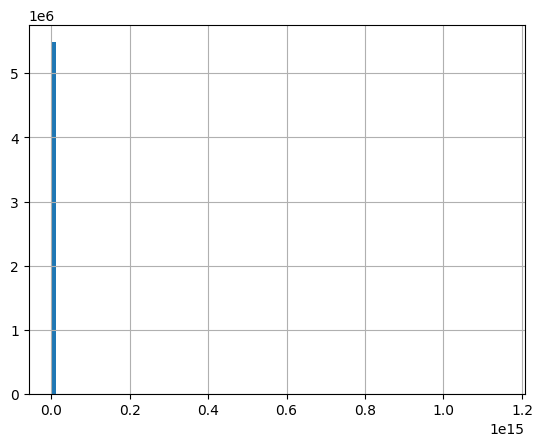

In [30]:
df['gas_price'].hist(bins=100)

<Axes: >

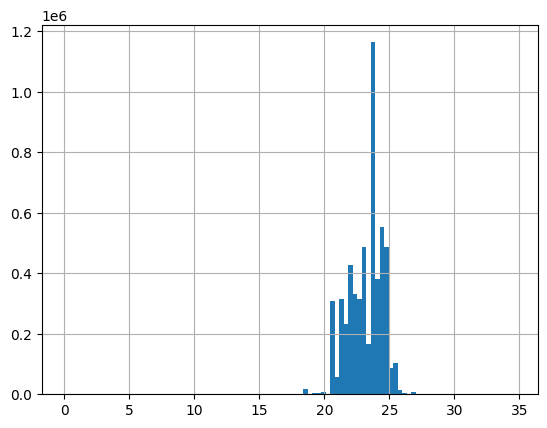

In [31]:
np.log1p(df['gas_price']).hist(bins=100)

In [32]:
# renumber from_address and to_address starting from 0 and update the dataframe
unique_ids = pd.concat([df['from_address'], df['to_address']]).unique()
# create a mapping from the original ID to a new ID
id_map = {old_id: new_id for new_id, old_id in enumerate(unique_ids)}
# replace the original IDs with the new IDs
df['from_address'] = df['from_address'].apply(lambda x: id_map[x])
df['to_address'] = df['to_address'].apply(lambda x: id_map[x])
# convert timestamp to UNIX
df['block_timestamp'] = df['block_timestamp'].apply(lambda x: x.timestamp())

# normalize numerical columns
for col in df.columns:
    if col in ['from_address', 'to_address', 'phishing', 'receipt_status', 'block_timestamp', 'nonce', 'transaction_index']:
        continue
    df[col] = np.log1p(df[col])
    df[col] = (df[col] - df[col].mean()) / df[col].std()

In [33]:
# save the dataframe to a csv file
# if not os.path.exists('/mnt/data/ethereum-phishing-transaction-network/ethereum-phishing-transaction-network.csv'):
df.to_csv('/mnt/data/ethereum-phishing-transaction-network/ethereum-phishing-transaction-network.csv', index=False)

In [34]:
%load_ext autoreload
%autoreload 2
# add parent directory to the path
import sys
sys.path.append('../')
from src.datasets import EthereumPhishingTransactions
from src.datasets.util.mask import PretrainType

In [35]:
dataset = EthereumPhishingTransactions(
    root='/mnt/data/ethereum-phishing-transaction-network/ethereum-phishing-transaction-network-c.csv', 
    pretrain={PretrainType.MASK, PretrainType.LINK_PRED},
    split_type='temporal',
    
    splits=[0.6, 0.2, 0.2], 
    khop_neighbors=[100, 100]
)
start = time.time()
dataset.materialize()
logger.info(f"Dataset materialized in {time.time()-start} seconds.")

2024-07-23 13:00:13 - INFO - Creating graph...
2024-07-23 13:00:17 - INFO - Graph created in 3.4475977420806885 seconds.
2024-07-23 13:00:17 - INFO - Applying mask...
2024-07-23 13:00:17 - INFO - Loading masked columns from /mnt/data/ethereum-phishing-transaction-network/ethereum-phishing-transaction-network-c.csv.npy
2024-07-23 13:00:40 - INFO - Mask applied in 23.777350425720215 seconds.
2024-07-23 13:02:34 - INFO - Dataset materialized in 111.22740697860718 seconds.
